In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch
from torchvision.utils import make_grid
import numpy  as np
import matplotlib.pyplot as plt
import  image_loader as il


/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [2]:
alex = models.alexnet(pretrained=True)

num_features = alex.classifier[6].in_features
alex.classifier[6] = nn.Linear(num_features, 5) # output lables 
    

for i, j in alex.named_modules():
    print(i, j)

loader = il.DatasetLoader.initial()
train = loader.load_tensors(0, 100)
test = loader.load_tensors(100, 150)


 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [3]:
def to_3_dim_image(img):
        layer = img[0].tolist()
        t = torch.tensor([layer] * 3)
        t[t==0] = 0.5
        return t
        
def create_empty_image(shape = (3, 224, 224)):
        t = torch.zeros(shape)
        t[t==0] = 0.5
        return t

def visualize_cell(input_data:dict, output_data:dict):
    lables = [(i, to_3_dim_image(input_data[i])) if i in input_data else (i, create_empty_image()) for i in il.labels_attributes]
    lables.sort(key=lambda x:x[0])
    inputs = list(filter(lambda x: x[0] == 'input', input_data.items()))
    merged = lables + inputs    
    print(list(map(lambda x: x[0], merged)))
    imgs = make_grid(list(map(lambda x: x[1], merged)), padding=50).numpy()
    plt.imshow(np.transpose(imgs, (1,2,0)))
    plt.figure()
    
    output_lables = [(i, to_3_dim_image(output_data[i])) if i in output_data else (i, create_empty_image()) for i in il.labels_attributes]
    merged_lables = output_lables
    merged_lables.sort(key=lambda x:x[0])    
    print(list(map(lambda x: x[0], merged_lables)))
    imgs = make_grid(list(map(lambda x: x[1], merged_lables)), padding=50).numpy()
    plt.imshow(np.transpose(imgs, (1,2,0)))

/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


['globules', 'milia_like_cyst', 'negative_network', 'pigment_network', 'streaks', 'input']
['globules', 'milia_like_cyst', 'negative_network', 'pigment_network', 'streaks']


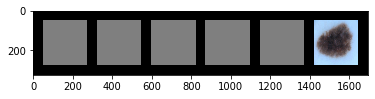

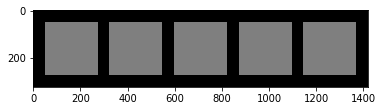

In [4]:
class GAIN:
    
    alpfa = 1
    dablu = 10
    def __init__(self, model, layer_name: str, gpu=False):
        self.model = model

        # set cuda
        self.gpu = gpu
        if self.gpu:
            self.model = self.model.cuda()
            self.tensor_source = torch.cuda
        else:
            self.tensor_source = torch

        self._last_activation = None
        self._last_grad = None

        self.__register_callbacks(layer_name)
        self.loss_cl = torch.nn.BCEWithLogitsLoss()

    def __register_callbacks(self, layer_name: str):

        def forward_callback(module, input_, output_):
            self._last_activation = output_

        def backward_callback(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        found_layer = False
        for idx, layer in self.model.named_modules():
            if idx == layer_name:
                found_layer = True
                layer.register_forward_hook(forward_callback)
                layer.register_backward_hook(backward_callback)
                break

        if not found_layer:
            raise ValueError("Not found layer:{}".format(layer_name))

    def train(self, train_set, epoch_number:int):
        
        for i in range(epoch_number):
            print(i)
        pass
    
    def russian_forward(self, input_image_data, mask_label_data, label_data):
        # build attention map
        output_classification = self.model(input_image_data)

        # required for get dx / dy for substitution to eq 1
        grad_target = (output_classification.float() * label_data).sum()
        grad_target.backward(gradient=output_classification * label_data, retain_graph=True)

        self.model.zero_grad()

        # Eq 1
        # find w_c from evaluate grad model for specified layer
        layer_gradient = self._last_grad
        # TODO what dim has layer_gradient
        w_c = F.avg_pool2d(layer_gradient, (layer_gradient.shape[-2], layer_gradient.shape[-1]), 1)
        # TODO why mul not div
        w_c_new_shape = (w_c.shape[0] * w_c.shape[1], w_c.shape[2], w_c.shape[3])
        w_c = w_c.view(w_c_new_shape).unsqueeze(0)

        # Eq 2
        # reshape current weights for compability with w_c
        f_weights = self._last_activation
        f_weights_new_shape = (f_weights.shape[0] * f_weights.shape[1], f_weights.shape[2], f_weights.shape[3])
        f_weights = f_weights.view(f_weights_new_shape).unsqueeze(0)

        a_c = F.relu(F.conv2d(f_weights, w_c))
        a_c = F.upsample(a_c, size=input_image_data.size()[2:], mode='bilinear')
        # here for a_c maybe add| upsample (augumentation), but not now

        # calculate old plain classification loss
        loss_cl = self.loss_cl(output_classification, label_data)

        # her we has output_classification, classification_loss, a_c

        i_star = self.__mask_image(input_image_data, a_c).detach()
        
        # here we want decrease weights, which are'nt marked by previous model as segment-importanse 
        output_am = self.model(i_star)
        
        loss_am = (F.sigmoid(output_am) * label_data).sum() / label_data.sum().type(self.tensor_source.FloatTensor)
        
        loss_e = ((mask_label_data - i_star) ** 2).sum()
        loss_total = loss_cl + self.alpfa * loss_am + self.dablu * loss_e
        # print("{}\n{}\n{}".format(loss_cl, loss_am, loss_e))
        # visualize_cell({'input':i_star[0]}, {})
        return loss_total, loss_cl, loss_am, loss_e, a_c, i_star 
        
    sigma = 0.1
    omega = 0.9

    def __mask_image(self, data_image, a_c):
        # Eq 4
        # I dont understand bellow 3 lines
        a_c_min = a_c.min()
        a_c_max = a_c.max()
        a_c = (a_c - a_c_min) / (a_c_max - a_c_min)
    
        t_a_c = F.sigmoid(self.omega * (a_c - self.sigma)).squeeze()
        # Eq 3
        masked_image = data_image - (data_image * t_a_c)
        return masked_image


gg = GAIN(alex, "features.10")

vector = torch.tensor([[1, 0, 0, 0, 0]]).float()


gg.russian_forward(torch.tensor([train[0]['input'].tolist()]), 
                   torch.tensor([train[0]['streaks'].tolist()]), vector)

visualize_cell({'input':train[0]['input']}, {})
